In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import requests 
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import os
%matplotlib inline

In [25]:
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [26]:
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

In [27]:
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [28]:
ticker = ["SPY"]
#set start and end dates
start_date = pd.Timestamp("2020-11-22", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-11-22", tz="America/New_York").isoformat()
# Set timeframe to one day (1D) for the Alpaca API
timeframe = "1D"
# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [29]:
ticker_df = alpaca.get_barset(
    ticker,
    timeframe,
    start = start_date,
    end = end_date,
    limit = limit_rows
).df
ticker_df.head()



SPY                                    
                             open     high      low   close    volume
time                                                                 
2020-11-23 00:00:00-05:00  357.28  358.790  354.865  357.47  49938331
2020-11-24 00:00:00-05:00  360.21  363.805  359.290  363.19  49862168
2020-11-25 00:00:00-05:00  363.13  363.160  361.480  362.65  35309156
2020-11-27 00:00:00-05:00  363.84  364.180  362.580  363.65  46840189
2020-11-30 00:00:00-05:00  362.83  363.120  359.170  362.00  67154075

In [30]:
btc_df = pd.read_csv(
    Path("./Resources/BTC-USD.csv"), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)
signals_df = btc_df.loc[:, ["Close"]]
signals_df["Actual Returns"] = signals_df["Close"].pct_change()
signals_df = signals_df.dropna()


In [31]:
short_window = 14
long_window = 30                 ## Setting the SMAs for the strategy 


signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

In [32]:
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

In [33]:
signals_df['Signal'].value_counts()

 1.0    176
-1.0    160
Name: Signal, dtype: int64

In [34]:
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

<AxesSubplot:xlabel='Date'>

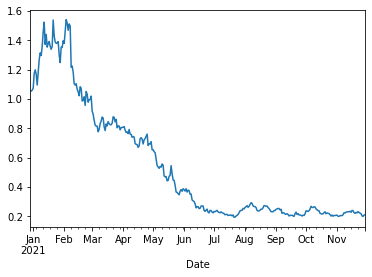

In [36]:
(1 + signals_df['Strategy Returns']).cumprod().plot()   ## plotted returns to make sure we are doing ok 


In [37]:
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()    ## adding the X for machine learning 

In [38]:
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    176
-1.0    160
Name: Signal, dtype: int64

In [39]:
training_begin = X.index.min()

In [40]:
training_end = X.index.min() + DateOffset(months=6) 

In [41]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [42]:
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

In [43]:
scaler = StandardScaler()   ## Scaling the data 


X_scaler = scaler.fit(X_train)


X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [44]:
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [45]:
svm_testing_report = classification_report(y_train, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.53      0.53      0.53        90
         1.0       0.54      0.54      0.54        93

    accuracy                           0.54       183
   macro avg       0.54      0.54      0.54       183
weighted avg       0.54      0.54      0.54       183



In [48]:
# Create a predictions DataFrame 
predictions_df =  pd.DataFrame(index=X_train.index)        ## used the index from X_train as the values were not matching up with X_test and we are just looking to match the index

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Strategy Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Actual Returns']

<AxesSubplot:xlabel='Date'>

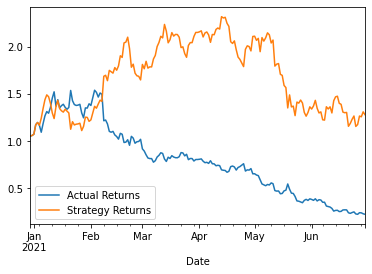

In [49]:
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()